# Lexical particularities of Alorese

This notebook shows how to use LexiRumah to investigate the lexical differences between
two groups of languages in LexiRumah. As example, compare the lexicon of Alorese lects ([alor1247](http://glottolog.org/resource/languoid/id/alor1247)) with the lexicon of all other lects of Lamaholot ([lama1292](http://glottolog.org/resource/languoid/id/lama1292)) lects.

First we import a variety of necessary modules and define constants.

In [3]:
# Import generally useful modules
%matplotlib inline
from matplotlib import pyplot
import numpy
import itertools
from bisect import bisect
from collections import defaultdict, OrderedDict

In [4]:
# Import pylexirumah and related objects
from clldutils.path import Path
import pylexirumah
from pylexirumah.util import glottolog_clade, get_dataset, lexirumah_glottocodes

# Load the LexiRumah database
lexirumah = get_dataset()

We define the language groups: `alorese` will be all alorese lects in LexiRumah, `lamaholot` will contain all sedentary Lamaholot lects (spoken on Solor, Flores, Lembata etc., but not the Alorese lects of Alor and Pantar). In order to check for inheritance and cross-family borrowings, we define `an` and `tap` to be the groups of all other lects in the database, by family.

In [5]:
# This may take some time, our implementation of `glottolog_clade` is not built for speed.

alorese = glottolog_clade("alor1247", lexirumah)
print(alorese)

lamaholot = glottolog_clade("lama1292", lexirumah) - alorese
print(lamaholot)

floreslembata = glottolog_clade("flor1239", lexirumah) - alorese - lamaholot

an = glottolog_clade("aust1307", lexirumah) - alorese - lamaholot - floreslembata
tap = glottolog_clade("timo1261", lexirumah)

rest = set(lexirumah_glottocodes(lexirumah)) - alorese - lamaholot - floreslembata - an - tap
# There should not be any languages in the rest
assert not rest, "Non-empty rest: {:}".format(rest)

groups = [alorese, lamaholot, floreslembata, an, tap]

{'alor1247-munas', 'alor1247-pandai', 'alor1247-baran', 'alor1247-marisa', 'alor1247-besar'}
{'lama1277-lewom', 'lama1277-lewop', 'lama1277-paina', 'lama1277-ileap', 'lama1277-belan', 'lama1277-tanju', 'lama1277-lamat', 'lama1277-lamak', 'lama1277-dulhi', 'lama1277-wuake', 'lama1277-lerek', 'lama1277-lewob', 'lama1277-lewog', 'lama1277-lamah', 'lama1277-kalik', 'lama1277-watan', 'lama1277-minga', 'lama1277-kiwan', 'lama1277-lewoe', 'lama1277-baipi', 'lama1277-lamal', 'lama1277-bama', 'lama1277-adona', 'lama1277-lewok', 'lama1277-lewot', 'lama1277-botun', 'lama1277-merde', 'lama1277-waiwa', 'lama1277-waiba', 'lama1277-lewuk', 'lama1277-lewoi', 'lama1277-horow', 'lama1277-mulan', 'lama1277-imulo', 'lama1277-ritae', 'lama1277-pukau'}


The LexiRumah database contains a `CognateTable`, which associates forms with cognate classes. In principle, different sources can assign one form to different classes. This is not the case at the moment where all forms are automatically generated. Going forwards, it will be a useful assumption that the newer cognate judgements occur later in the file, which is the semantics the by the following code block takes into account.

Explicitly prioritizing or ignoring a specific source can still be done by adding a filtering `if` statement to the following `for` loop.

In [6]:
# Aggregate cognate data from the Form and Cognate table.

# First, load the relevant content of the CognateTable into memory as dictionary.
cognateclass_by_form = {}
for cognate in lexirumah["CognateTable"].iterdicts():
    cognateclass_by_form[cognate["Form_ID"]] = cognate["Cognateset_ID"]

# Then, generate a sequence of all cognate classes, storing associations from the
# cognate class ID to the set of (concept, lect, form) tuples representing all forms
# belonging to that class.
cognates_by_class = {}
for form in lexirumah["FormTable"].iterdicts():
    concept = form["Concept_ID"]
    lect = form["Lect_ID"]
    cognates_by_class.setdefault(
        cognateclass_by_form.get(form["ID"]), set()).add(
        (concept, lect, form["Form"]))

In order to compare the lexical material of the two language groups, we now check what cognate classes are attested in which of the language groups. For now, all cognate sets in LexiRumah are restricted to one concept each, which simplifies the following calculation and interpretation.

In [7]:
# attested_cognate_sets is a dictionary, which associates concepts to a list of sets.
# The list contains one set for each language group defined above, and the set is a
# set of all cognate set IDs that express that concept in at least one lect of that
# group.
attested_cognate_sets = defaultdict(lambda: [set() for g_ in groups])
for name, cognates in cognates_by_class.items():
    lects = {lect for (concept, lect, form) in cognates}
    concept, _, _ = next(iter(cognates))
    
    for g, group in enumerate(groups):
        if lects & group:
            attested_cognate_sets[concept][g].add(name)

Now we can compare the lexicon. Starting with the most ‘stable’ concepts (we don't have a direct measure of stability, but we can assume that concepts with fewer cognate classes are more stable), we list those concepts where Alorese and Lamaholot have different cognate classes.

In [8]:
# Sort concepts by stability, by running an insertion sort with the help of bisect.
concepts = []
concept_stability = []
for concept, concept_classes in attested_cognate_sets.items():
    order = len(
        set.union(*concept_classes))
    i = bisect(concept_stability, order)
    concepts.insert(i, concept)
    concept_stability.insert(i, order)
# concepts is now a list of concept IDs, in order of stability.

cognateset_pattern_counts = numpy.zeros((2,) * len(groups) + (len(concepts),))

# Count the number of cognate classes for each pattern.
for c, concept in enumerate(concepts):
    attested_in_groups = attested_cognate_sets[concept]

    for pattern in itertools.product([0, 1], repeat=len(groups)):
        cognate_classes_for_pattern = set.union(*attested_in_groups)
        for present, classes in zip(pattern, attested_in_groups):
            if present:
                cognate_classes_for_pattern &= classes
            else:
                cognate_classes_for_pattern -= classes
        
        cognateset_pattern_counts[pattern][c] = len(cognate_classes_for_pattern)

# Genome-style plots

Every vertical line in the following bar plots corresponds to a concept; stable concepts on the left, unstable concepts on the right. Inside each bar, different types of cognate classes are plotted – every cognate class attested in that group is plotted with the same percentage, with colors corresponding to the apparent origin of the form.

In [9]:
def genomestyle(group_index=None, order=None):
    # Prepare the figure
    pyplot.gcf().set_size_inches((14, 3))
    #pyplot.axis('off')
    #pyplot.gca().get_xaxis().set_visible(False)
    #pyplot.gca().get_yaxis().set_visible(False)

    # Only count cognate classes present in group `group_index` – set all counts where
    # `group_index` is absent to 0.
    counts = cognateset_pattern_counts.copy()
    if group_index is not None:
        counts.swapaxes(group_index, 0)[0] = 0

    # Where `normalize` is 0, no forms for that concept are given. Ignore.
    b = numpy.zeros((len(concepts), len(colorize)))
    
    for c, (color, cells) in enumerate(colorize.items()):
        bar_height = 0
        for cell in cells:
            bar_height = counts[cell] + bar_height
        b[:, c] = bar_height

    # This complex expression sorts the bars as we want them, but keeps the data
    # structure an array for easier calculations.
    order = order or sorted(
        range(len(b)),
        key=lambda x: tuple(
            sum(b[x][n:]) for n in range(len(b[x]))))
    sorted_bars = b[order]

    bottom = 0
    for color, bars in zip(colorize, sorted_bars.T):
        pyplot.bar(
            range(len(bars)),
            bars,
            1.0,
            bottom = bottom,
            color = color)
        bottom = bottom + bars
    
    pyplot.xlabel("Concept")
    pyplot.ylabel("Number of classes")
    return order

In [10]:
colorize = OrderedDict()

Some cognate classes are present in Alorese and other AN languages (including the provided reconstructions of pMP and pAN). If they follow the hierarchy (see below), we give them all the same orange color. (In addition, this color is given to all hierarchically inherited forms that did not make it into Alorese, but this is only for completion's sake.)

That is, all similarity classes found in every group for one of the following diagrams is colored orange.

    (TAP < ) AN       (TAP < ) AN                 (TAP < ) AN             (TAP < ) AN
                                \                           \                       \
                 FL             FL     FL                   FL        FL            FL
                                        \                    \         \             \
                    LH                  LH      LH           LH        LH            LH
                                                 \                      \             \
                                                 AL                     AL            AL



As an exception from that hierarchical inheritance color, Forms found in Alorese which are judged dissimilar to any other forms get the color purple marking them as “Alorese-specific”.

In [11]:
# Hierarchical inheritance
colorize[(1, 0.7, 0.2)] = [
    (1, 1, 1, 1, 1),
    (0, 1, 1, 1, 1),
    (0, 0, 1, 1, 1),
    (0, 0, 0, 1, 1),
    (1, 1, 1, 1, 0),
    (0, 1, 1, 1, 0),
    (0, 0, 1, 1, 0),
    (0, 0, 0, 1, 0),
    (1, 1, 1, 0, 0),
    (0, 1, 1, 0, 0), 
    (0, 0, 1, 0, 0),
    (1, 1, 0, 0, 0),
    (0, 1, 0, 0, 0)]

Similarity classes that are found in TAP, and outside TAP only in Alorese, are a priori easily explained as TAP loans, so they will all be colored green. (In the complete listing, that color is also chosen for all classes found in TAP, but not outside that family.)

In [12]:
# TAP forms
colorize[(0.0, 0.8, 0.0)] = [
     (1, 0, 0, 0, 1),
     (0, 0, 0, 0, 1)]
        

If a cognate class is attested in Alorese and other Flores-Lembata languages, but not in any Lamaholot dialect, that is slightly unexpected under the hypothesis that Alorese is a daughter, not a sister, of Lamaholot. We color those similarity classes in yellow.

Similarly, we assign the same yellow color to all classes that have an unexpected distribution. This includes
 1. All forms that “skipped” a clade in the inhertance hierarchy, eg. similarity classes found in AN, Alorese, and other Flores-Lembata languages, but not in any Lamaholot dialect;
 2. Similarity classes found in Timor-Alor-Pantar languages, but which in the Austronesian languages are found only in the wider Flores-Lembata languages.
 

In [13]:
# Unexpected distribution
colorize[(0.9, 0.9, 0.0)] = [
    (1, 0, 1, 1, 1),
    (1, 0, 1, 1, 0),
    (1, 0, 1, 0, 0),
    (1, 0, 0, 1, 1),
    (1, 1, 0, 1, 1),
    (0, 1, 0, 1, 1), 
    (1, 0, 0, 1, 0),
    (1, 1, 0, 1, 0),
    (0, 1, 0, 1, 0),
    (1, 1, 1, 0, 1),
    (0, 1, 1, 0, 1),
    (0, 0, 1, 0, 1),
    (1, 1, 0, 0, 1),
    (0, 1, 0, 0, 1),
    (1, 0, 1, 0, 1)]


In [14]:
# Alorese forms
colorize[(0.8, 0.1, 1.0)] = [
    (1, 0, 0, 0, 0)]

In [15]:
# This should be all combinations.
all_patterns = [(0,) * len(groups)]
for patterns in colorize.values():
    all_patterns.extend(patterns)
for i, j in zip(sorted(all_patterns), sorted(itertools.product([0, 1], repeat=len(groups)))):
    if i!=j:
        print("expected:", j, "but found:", i)

# Genome-style plot of the entire database
The plots below sort concepts by their local stability. If you want a specific order, eg. order by global stability, you have to calculate that order and pass it to those plotting functions as argument. Here, the output is the distribution of these classes over the entire database.

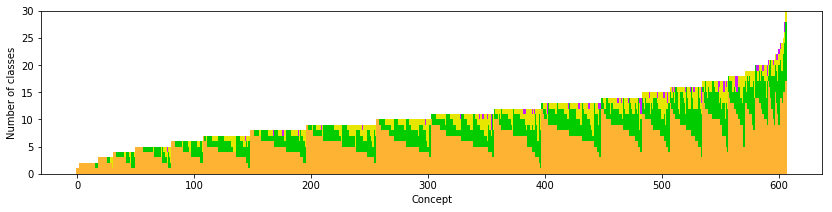

In [16]:
order = genomestyle(None, order=None)

## TAP forms

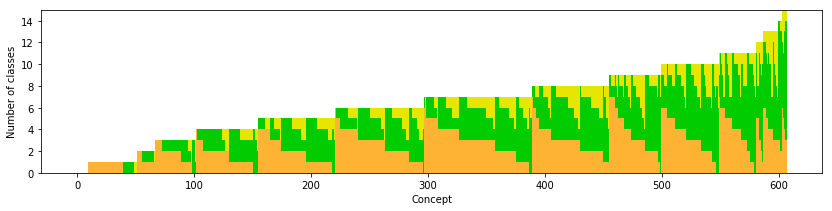

In [17]:
_ = genomestyle(4, order=None)

## Alorese forms

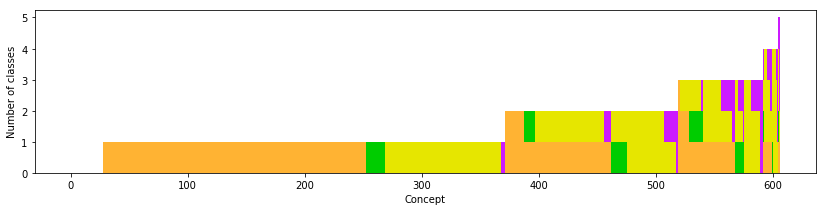

In [18]:
_ = genomestyle(0, order=None)

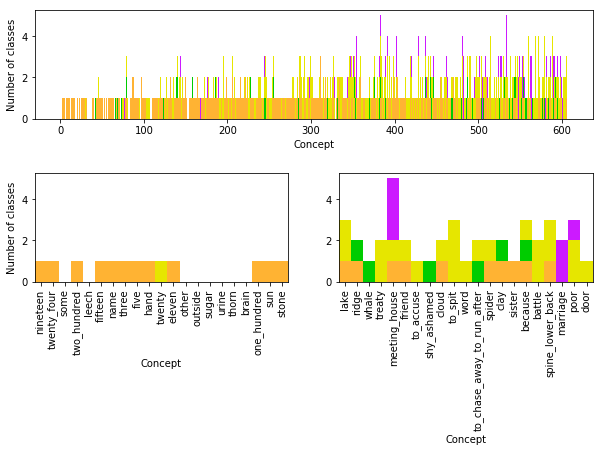

In [19]:
pyplot.subplot2grid((2, 2), (0, 0), colspan=2)

_ = genomestyle(0, order=order)

concepts_in_order = [concepts[o] for o in order]

pyplot.subplot2grid((2, 2), (1, 0))
_ = genomestyle(0, order=order)
pyplot.xticks(range(len(concepts)), concepts_in_order, rotation='vertical')
pyplot.xlim(19.5, 40.5)

pyplot.subplot2grid((2, 2), (1, 1))
_ = genomestyle(0, order=order)
pyplot.xticks(range(len(concepts)), concepts_in_order, rotation='vertical')
pyplot.xlim(529.5, 550.5)
pyplot.ylabel("")

pyplot.gcf().set_size_inches((10, 5))
pyplot.subplots_adjust(hspace=0.5)

pyplot.savefig("Fig7.eps", format='eps', dpi=600)

(19.5, 80.5)

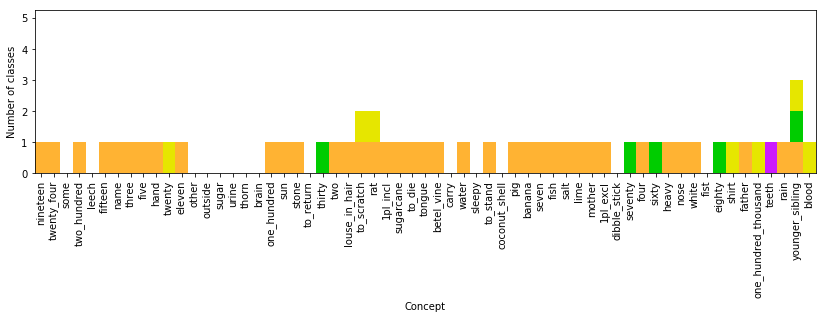

In [20]:
_ = genomestyle(0, order=order)
pyplot.xticks(range(len(concepts)), concepts_in_order, rotation='vertical')
pyplot.xlim(19.5, 80.5)

## Examples: a few of the concepts seen in the figures above

In [21]:
for c in attested_cognate_sets["lizard"][0]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)


AL
alor1247-munas təˈkːɛʔ
alor1247-besar taˈkːe
alor1247-pandai taˈkːe
LH
lama1277-adona ˈtɜke
lama1277-lewoi ˈtəkɛʔ
lama1277-kalik təˈkɛk
lama1277-lerek təˈkɛk
FL
sika1262-hewa təkeː
keda1252-leuba tɛˈkɛʔ
AN
tetu1245-suai toko
p-mala1545-acd təktək
waim1252 tʰeki
indo1316-lexi tokek
waim1252 toke
keoo1238 teke
kema1243-kaila toko
tetu1245-vique toko
eray1237 teke
west2547-welaun toko
komo1261 təke
koto1251 ʔkukaʔ
mang1405 təke
koto1251 bikruʔu
dela1252 teke
ngao1245-watum təˈke
dhao1237 təke
ngad1267 təke
ngao1245-oja təˈke
weta1243 teki
koto1251 ʔteke
bima1247 deke
lioo1240 təke
funa1237 ktokeʔ
keoo1238 ebe
nage1237 təˈke
lole1239 teke
ende1246 tekẽ
TAP
wers1238-taram peko
kira1248 taˈkok
adan1251-otvai ˈtɛko
adan1251-lawah teko
abui1241-takal te̞̞qɔʔ
rett1240 tek
buna1278-bobon thɔkɔh
buna1278-suai thɔkɔh
blag1240-warsa texe
teiw1235 taqoq
blag1240-kulij tekeʔ
kabo1247 teko
blag1240-nule teˈke
abui1241-ulaga taŋkok
blag1240-tuntu texe
sarr1247-nule taqo
rett1240 tɛk
abui1241-takal t

In [22]:
for c in attested_cognate_sets["thirteen"][0]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)


AL
alor1247-pandai kəˈrtou_ˈilak_ˈtalːɔ
alor1247-besar kartou_ˈilaka_ˈtalːɔ
alor1247-munas kərˈtou_ˈilak_təˈlːɔ
LH
lama1277-lewoi pulo_noʔoŋ_ˈtɛlːo
lama1277-adona pulok_tɜlo
lama1277-lerek heˈpulo_no_təl
lama1277-kalik ˈspulo_no_təˈlu
FL
sika1262-hewa pulu_ʋot_təlu
keda1252-leuba pulaʔ_ˈtɛlu
AN
indo1316-lexi tiga_bəlas
eray1237 hela_eha_isin_hatelu
tetu1245-suai sanulu_resin_tolu
ende1246 sa_mburhu_ˈesa_terhu
lole1239 sanahulu_telu
bima1247 sampuru_tolu
koto1251 boʔ+esa_m_tenu
waim1252 baseː_resi_kai_telu
funa1237 smuːl_tilu
tetu1245-vique sanulu_resin_tolu
west2547-welaun sakulu_resin_tolu
kema1243-kaila sapulu_resi_tolu
tiii1241 salahulu_telu
TAP
pura1258 aˈrinu_bɛlta_ˈtue
adan1251-lawah airnu_waliŋ_towo
abui1241-fuime wal_sua
adan1251-otvai ˈʔernu_faˈliŋ_ˈtou
kama1365 ataːk_nok_waːl_su
wers1238-marit ad_ˈjok_gresiŋ_ˈtu
kaer1234 xar_nuk_bɛti_ʔtug
kira1248 karnuku_wal_suwa
baka1276 ar_nu_betal_tue
maka1316 ru_resi_loˈlitu
sawi1256 aˈdaku_ˈwarisin_ˈtuɑ
abui1241-ulaga kar_nuk_wal_sua
bu

In [23]:
for c in attested_cognate_sets["tongue"][0]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)


AL
alor1247-pandai wɛwɛl
alor1247-besar fɛˈfɛlɛŋ
alor1247-baran fɛfɛl
alor1247-munas wɛwɛl
LH
lama1277-lewop efel
lama1277-merde ewelə
lama1277-lewot efel
lama1277-waiba wewel
lama1277-botun wewe
lama1277-horow wewer
lama1277-wuake ewel
lama1277-adona ˈɜwɜˈrɜt
lama1277-bama wewel
lama1277-lewog wewel
lama1277-lewuk ewel
lama1277-lewok ewel
lama1277-lewom wewe
lama1277-watan wewer
lama1277-pukau wewel
lama1277-baipi wewe
lama1277-tanju wewel
lama1277-lewoe ebe
lama1277-imulo efeləs
lama1277-lewoi ˈweweˈləŋ
lama1277-lamat eblə
lama1277-ritae wewel
lama1277-mulan ewel
lama1277-lerek eˈwel
lama1277-kiwan wewejək
lama1277-lamal efel
lama1277-ileap ewel
lama1277-belan ewel
lama1277-minga efel
lama1277-lamah ewel
lama1277-lewob wewe
lama1277-waiwa wewer
lama1277-lamak ewel
lama1277-paina eweləg
lama1277-dulhi wewen
lama1277-kalik eˈvɛl
lama1277-kalik ewel
FL
keda1252-leuwa æbæl
keda1252-leuba ebel
keda1252 ebel
AN
west2547-welaun berot
TAP
maka1316 ifiˈleru
fata1247 ipil
oira1263 uˈhul
sarr12

In [24]:
for c in attested_cognate_sets["church"][0]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)


AL
alor1247-pandai uma_gəˈrɛdʒa
alor1247-besar gaˈrɛd͡ʒa
alor1247-munas gərˈdʒa
LH
lama1277-adona gɜˈrɛdʒa
lama1277-lewoi geˈrɛd͡ʒa
FL
sika1262-hewa gered͡ʒa
keda1252-leuba gəˈrɛdʒa
AN
west2547-welaun gəred͡ʒa
waim1252 kreda
indo1316-lexi gəred͡ʒa
ngao1245-oja gəˈredʒa
mang1405 gəredʒa
weta1243 krei
lioo1240 gəredʒa
rong1269 gəredʒa
tetu1245-vique uma_ˈkreda
funa1237 kred͡ʒa
tetu1245-suai uma_ˈkreda
nage1237 gəˈredʒa
ngao1245-watum gəˈredʒa
koto1251 krei
kema1243-kaila gə̆red͡ʒa
waim1252 igrisa
TAP
rett1240 garad͡ʒa
lamm1241-westp gria
maka1316 igreza
buna1278-bobon igreza
kelo1247-hopte gəˈreɟ
teiw1235 gəˈreja
kaer1234 griʔja
buna1278-suai igreza
fata1247 igrɛɟa
pura1258 gaˈrija
adan1251-otvai gaˈrɛɟa


In [25]:
for c in attested_cognate_sets["claw"][0]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)
    print()

print()
print("For context, the forms in Lamaholot:")
for c in attested_cognate_sets["claw"][1]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)

AL
alor1247-munas kɛla_ˈleiŋ
LH
FL
AN
tetu1245-vique manu_ain
tetu1245-suai manu_ain
TAP

AL
alor1247-pandai kˈrako
alor1247-besar gaˈraku
LH
lama1277-lerek kabəˈlən
lama1277-adona kɜˈmukure
FL
sika1262-hewa gəroʔ
keda1252-leuba kaˈruŋ
sika1262-hewa geri
AN
koto1251 ʔpisuʔ
idat1237 kaˈramɑs
west2547-welaun saberit
laka1255 kraˈhut
eray1237 kalasun
kema1243 grapi
kema1243 grapa
p-mala1545-acd kuhkuh
weta1243 kera
indo1316-lexi tʃakar
tetu1246 lɛːs
TAP
buna1278-suai giseʔ
buna1278-malia giˈsɛ
rett1240 koːhiŋ
wers1238-marit səˈkɛri
buna1278-bobon galakha
teiw1235 kuras
kelo1247-bring gɛkuh
sawi1256 kəˈriki
kama1365 kuisiŋ
kaer1234 krabis
pura1258 hurak

AL
alor1247-baran limɑŋ_taˈnuŋgul
LH
FL
AN
TAP


For context, the forms in Lamaholot:
AL
LH
lama1277-lewoi təˈnuʔi
FL
AN
TAP
AL
alor1247-pandai kˈrako
alor1247-besar gaˈraku
LH
lama1277-lerek kabəˈlən
lama1277-adona kɜˈmukure
FL
sika1262-hewa gəroʔ
keda1252-leuba kaˈruŋ
sika1262-hewa geri
AN
koto1251 ʔpisuʔ
idat1237 kaˈramɑs
west2547-welau

In [26]:
for concept in concepts:
    by_group = attested_cognate_sets[concept]
    if by_group[0] != by_group[1]:
        if by_group[0] and by_group[1]:
            fl_skipping_l = (by_group[0] & by_group[2]) - by_group[1]
            an_skipping_l = (by_group[0] & by_group[3]) - by_group[1]
            skipping = fl_skipping_l | an_skipping_l
            a_but_not_l = by_group[0] - by_group[1]
            l_skipping_a = by_group[1] - by_group[0]

            print("Concept ‘{:}’ is different between Alorese and Lamaholot.".format(
                concept))
            print()
            if (a_but_not_l - skipping) - by_group[4]:
                print("", "Alorese innovated the following forms:")
                for cognateclass in a_but_not_l - skipping:
                    print("", cognates_by_class[cognateclass])
            if (a_but_not_l - skipping) & by_group[4]:
                print("", "Alorese shares the following forms with TAP languages:")
                for cognateclass in a_but_not_l - skipping:
                    print("", cognates_by_class[cognateclass])
            if skipping:
                print("", "Alorese shares the following forms with other AN languanges, but not Lamaholot:")
                for cognateclass in skipping:
                    print("", cognates_by_class[cognateclass])
            if l_skipping_a:
                print("", "One or more Lamaholot dialects innovated forms not found in Alorese:")
                for cognateclass in l_skipping_a:
                    print("", cognates_by_class[cognateclass])
            if by_group[1] & by_group[0]:
                print()
                print(" ", "Just for clarity:")
                print(" ", "There are also the following similarity classes shared between Alorese and LH.")
                for cognateclass in by_group[1] & by_group[0]:
                    print(" ", cognates_by_class[cognateclass])
        elif by_group[0]:
            print("Concept {:} is attested only in Alorese".format(concept))
        elif by_group[1]:
            print("Concept {:} is attested only in Lamaholot".format(concept))
        print("\n\n")
        


Concept ‘hand’ is different between Alorese and Lamaholot.

 One or more Lamaholot dialects innovated forms not found in Alorese:
 {('hand', 'abui1241-takal', 'tä.ˈtäŋ_pääkä'), ('hand', 'oira1263', 'ˈtana'), ('hand', 'fata1247', 'tana'), ('hand', 'kafo1240', 'tɑtɑŋ'), ('hand', 'maka1316', 'tana'), ('hand', 'p-timo1261', '+tana'), ('hand', 'kaer1234', 'taʔtaŋ_wa'), ('hand', 'teiw1235', 'getan'), ('hand', 'lamm1241-westp', '+tːaŋ'), ('hand', 'buna1278-malia', 'gɔn'), ('hand', 'abui1241-ulaga', 'tataŋ_paːka'), ('hand', 'hama1240', 'nataŋ'), ('hand', 'kelo1247-bring', 'gətɑn'), ('hand', 'p-east2519', '+tana'), ('hand', 'wers1238-marit', 'təteŋ'), ('hand', 'pura1258', 'tataŋ'), ('hand', 'wers1238-taram', 'neteŋ'), ('hand', 'kelo1247-hopte', 'teˈtan'), ('hand', 'adan1251-otvai', 'ʔaˈtaŋ'), ('hand', 'buna1278-bobon', 'gɔn'), ('hand', 'indo1316-lexi', 'taŋan'), ('hand', 'buna1278-suai', 'gɔn'), ('hand', 'rett1240', 'ataŋ_bɔga'), ('hand', 'kula1280-lanto', 'tənna'), ('hand', 'kama1365', 'nɑtaŋ'

Concept ‘to_sell’ is different between Alorese and Lamaholot.

 Alorese shares the following forms with other AN languanges, but not Lamaholot:
 {('to_sell', 'alor1247-besar', 'paˈnahaŋ'), ('to_sell', 'alor1247-munas', 'pˈnahaŋ'), ('to_sell', 'tetu1245-suai', 'faʔen'), ('to_sell', 'sarr1247-adiab', 'maʔaŋ'), ('to_sell', 'tetu1245-vique', 'faʔen'), ('to_sell', 'dhao1237', 'pahia'), ('to_sell', 'seba1248', 'pevie'), ('to_sell', 'sarr1247-nule', 'maʔaŋ'), ('to_sell', 'teiw1235', 'ʔan'), ('to_sell', 'kaer1234', 'mɛano'), ('to_sell', 'alor1247-pandai', 'pˈnahaŋ'), ('to_sell', 'eray1237', 'haːŋ')}
 One or more Lamaholot dialects innovated forms not found in Alorese:
 {('to_sell', 'lama1277-lewoi', 'ˈduʔuŋ'), ('to_sell', 'kula1280-lanto', 'wetaˈjən'), ('to_sell', 'keda1252-leuba', 'duˈruŋ'), ('to_sell', 'lama1277-kalik', 'duˈrum'), ('to_sell', 'indo1316-lexi', 'd͡ʒual'), ('to_sell', 'lama1277-lerek', 'duˈrum'), ('to_sell', 'lama1277-adona', 'ˈduʔũ')}



Concept ‘no_not’ is different between 

 {('knife', 'kuii1253', 'dur'), ('knife', 'tetu1245-vique', 'tudik'), ('knife', 'tetu1246', 'tuˈdik'), ('knife', 'kabo1247', 'dur'), ('knife', 'sika1262-hewa', 'tudi'), ('knife', 'kafo1240', 'dʊr'), ('knife', 'rong1269', 'tuɗi'), ('knife', 'blag1240-kulij', 'tudik'), ('knife', 'dhao1237', 'tuɗi'), ('knife', 'alor1247-baran', 'duˈri'), ('knife', 'baka1276', 'tudik'), ('knife', 'hama1240', 'du.ir'), ('knife', 'adan1251-otvai', 'ˈduir'), ('knife', 'kelo1247-hopte', 'duːr'), ('knife', 'maka1316', 'suti_kaʔu'), ('knife', 'nede1245', 't͡ʃija'), ('knife', 'blag1240-nule', 'tudik'), ('knife', 'alor1247-pandai', 'duri'), ('knife', 'weta1243', 'taːwa'), ('knife', 'kelo1247-bring', 'dʊːr'), ('knife', 'buna1278-suai', 't͡ʃuri_gɔl'), ('knife', 'alor1247-besar', 'duri'), ('knife', 'adan1251-otvai', 'ˈdir'), ('knife', 'west2547-welaun', 'tudik'), ('knife', 'buna1278-bobon', 't͡ʃuri_gɔl'), ('knife', 'palu1252', 'kəti'), ('knife', 'buna1278-malia', 't͡ʃuriˈʔigɔl'), ('knife', 'waim1252', 'turi'), ('knif

 One or more Lamaholot dialects innovated forms not found in Alorese:
 {('betel_nut_areca', 'lama1277-kalik', 'kleˈruk'), ('betel_nut_areca', 'lama1277-lerek', 'ˈkleruk')}

  Just for clarity:
  There are also the following similarity classes shared between Alorese and LH.
  {('betel_nut_areca', 'eray1237', 'pua'), ('betel_nut_areca', 'kula1280-lanto', 'pi'), ('betel_nut_areca', 'alor1247-baran', 'ʔufa'), ('betel_nut_areca', 'wers1238-marit', 'pui'), ('betel_nut_areca', 'rett1240', 'ɓi'), ('betel_nut_areca', 'buna1278-suai', 'pu'), ('betel_nut_areca', 'blag1240-kulij', 'bu'), ('betel_nut_areca', 'kaer1234', 'bui'), ('betel_nut_areca', 'atim1239', 'fu'), ('betel_nut_areca', 'p-timo1261', 'bui'), ('betel_nut_areca', 'indo1316-lexi', 'pinaŋ'), ('betel_nut_areca', 'kelo1247-hopte', 'buːi'), ('betel_nut_areca', 'waim1252', 'buo'), ('betel_nut_areca', 'rett1240', 'bi'), ('betel_nut_areca', 'kira1248', 'bui'), ('betel_nut_areca', 'abui1241-ulaga', 'wuu'), ('betel_nut_areca', 'buna1278-bobon',

 {('easy', 'lama1277-adona', 'ˈpəlelɛt'), ('easy', 'rett1240', 'vɛla'), ('easy', 'teiw1235', 'wul')}

  Just for clarity:
  There are also the following similarity classes shared between Alorese and LH.
  {('easy', 'sika1262-hewa', 'plaːuˈhaː'), ('easy', 'lama1277-kalik', 'klɔˈsʊm'), ('easy', 'alor1247-besar', 'lohi')}



Concept ‘grasshopper’ is different between Alorese and Lamaholot.

 One or more Lamaholot dialects innovated forms not found in Alorese:
 {('grasshopper', 'lama1277-lewoi', 'kəˈtoko'), ('grasshopper', 'palu1252', 'tutəŋgo'), ('grasshopper', 'kula1280-lanto', 'akɨki'), ('grasshopper', 'sawi1256', 'aˈkiki'), ('grasshopper', 'kula1280-lanto', 'akəˈki')}

  Just for clarity:
  There are also the following similarity classes shared between Alorese and LH.
  {('grasshopper', 'bima1247', 'kamoa'), ('grasshopper', 'lama1277-adona', 'kɜˈmaroʔ'), ('grasshopper', 'alor1247-pandai', 'marɔ'), ('grasshopper', 'bima1247', 'kaɗuru'), ('grasshopper', 'lama1277-lerek', 'maˈyor'), ('gra

  Just for clarity:
  There are also the following similarity classes shared between Alorese and LH.
  {('to_turn', 'alor1247-munas', 'bɛhɔʔ'), ('to_turn', 'lama1277-adona', 'ˈpɛkɔt'), ('to_turn', 'lioo1240', 'beʔo'), ('to_turn', 'keda1252-leuba', 'heaʔ'), ('to_turn', 'lama1277-lerek', 'peŋoˈhaŋ'), ('to_turn', 'lole1239', 'heok')}
  {('to_turn', 'mang1405', 'səleko'), ('to_turn', 'alor1247-pandai', 'mikuŋ'), ('to_turn', 'nede1245', 'wagija'), ('to_turn', 'maka1316', 'kaˈili'), ('to_turn', 'keda1252-leuwa', 'ɛkuʔ'), ('to_turn', 'abui1241-takal', 'hä.ri.ˈnäl'), ('to_turn', 'tuku1254', 'gəˈlelu'), ('to_turn', 'alor1247-baran', 'lakɔŋ'), ('to_turn', 'abui1241-ulaga', 'akil'), ('to_turn', 'kama1365', 'miakiː'), ('to_turn', 'fata1247', 'kailɛ'), ('to_turn', 'lama1277-kalik', 'ɛˈgɔl'), ('to_turn', 'kama1365', '+kiː'), ('to_turn', 'keoo1238', 'digi'), ('to_turn', 'alor1247-pandai', 'gɔlɔ'), ('to_turn', 'alor1247-besar', 'heŋko'), ('to_turn', 'nede1245', 'magija'), ('to_turn', 'p-aust1307-abvd'